In [75]:
import pandas as pd
import sys
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib as joblib
import tensorflow as tf
from tensorflow import keras
from keras.models import model_from_json,Model, load_model
from keras.layers import Dense, Input, Activation, BatchNormalization,Add,Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback, TensorBoard

import datetime
from sklearn.model_selection import train_test_split
import os

In [76]:
os.getcwd()

'e:\\Codes\\Mantis-Shrimp-Eye-s-Collision-Avoidance'

In [3]:
os.chdir("../")
os.getcwd()

'e:\\Codes\\Mantis-Shrimp-Eye-s-Collision-Avoidance'

In [4]:
sys.path.append(os.getcwd()+"/tools")

In [77]:
from configmanager import ConfigurationManager
configurationManager = ConfigurationManager()

## Preprocess

In [78]:
dnn_rnn_dataset =  configurationManager.config_readable['dnn_rnn_dataset']
models_path_folder = configurationManager.config_readable['models_path_folder']

path_dnn_train = dnn_rnn_dataset+"fake_dnn_train.csv"
path_dnn_train = dnn_rnn_dataset+"dnn_train.csv"


df_train = pd.read_csv(path_dnn_train)
df_train

,flight_id,object_type,object,frame_id,left,top,width,height,area,image_path,range_distance
0,0001ba865c8e410e88609541b8f55ffc,Helicopter,Helicopter1,229,1551.358765,1121.692017,16.000000,16.000000,256.000000,D://airborne-detection-starter-kit/data/part1/...,698.099154
1,0001ba865c8e410e88609541b8f55ffc,Helicopter,Helicopter1,230,1559.000000,1123.400000,16.000000,16.000000,256.000000,D://airborne-detection-starter-kit/data/part1/...,692.553591
2,0001ba865c8e410e88609541b8f55ffc,Helicopter,Helicopter1,231,1561.330688,1119.515991,16.000000,16.000000,256.000000,D://airborne-detection-starter-kit/data/part1/...,687.144329
3,0001ba865c8e410e88609541b8f55ffc,Helicopter,Helicopter1,232,1564.058960,1123.598999,16.000000,16.000000,256.000000,D://airborne-detection-starter-kit/data/part1/...,681.758264
4,0001ba865c8e410e88609541b8f55ffc,Helicopter,Helicopter1,233,1563.531860,1124.573975,16.000000,16.000000,256.000000,D://airborne-detection-starter-kit/data/part1/...,676.482461
...,...,...,...,...,...,...,...,...,...,...,...
7491,0549559b37d741389e3dec0fcd62b161,Helicopter,Helicopter1,1189,772.307692,233.076923,146.923077,176.153846,25881.065089,D://airborne-detection-starter-kit/data/part1/...,50.643230
7492,0549559b37d741389e3dec0fcd62b161,Helicopter,Helicopter1,1190,716.923077,136.923077,170.000000,194.615385,33084.615385,D://airborne-detection-starter-kit/data/part1/...,46.777990
7493,0549559b37d741389e3dec0fcd62b161,Helicopter,Helicopter1,1191,654.615385,21.538462,188.461538,230.000000,43346.153846,D://airborne-detection-starter-kit/data/part1/...,43.162551
7494,0549559b37d741389e3dec0fcd62b161,Helicopter,Helicopter1,1192,593.076923,4.615385,203.846154,147.692308,30106.508876,D://airborne-detection-starter-kit/data/part1/...,39.686723


In [ ]:
'''
@dataclass
class ObjectTypes(Enum):
    Airplane = 0
    Helicopter = 1
    Bird = 2
    Drone = 3
    Flock = 4
    Airborne = 5
'''

In [79]:
df_train['object_type'].replace('Airplane', 0, inplace=True)
df_train['object_type'].replace('Helicopter', 1, inplace=True)
df_train['object_type'].replace('Bird', 2, inplace=True)
df_train['object_type'].replace('Drone', 3, inplace=True)
df_train['object_type'].replace('Flock', 4, inplace=True)
df_train['object_type'].replace('Airborne', 5, inplace=True)
df_train.head()

,flight_id,object_type,object,frame_id,left,top,width,height,area,image_path,range_distance
0,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,229,1551.358765,1121.692017,16.0,16.0,256.0,D://airborne-detection-starter-kit/data/part1/...,698.099154
1,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,230,1559.000000,1123.400000,16.0,16.0,256.0,D://airborne-detection-starter-kit/data/part1/...,692.553591
2,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,231,1561.330688,1119.515991,16.0,16.0,256.0,D://airborne-detection-starter-kit/data/part1/...,687.144329
3,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,232,1564.058960,1123.598999,16.0,16.0,256.0,D://airborne-detection-starter-kit/data/part1/...,681.758264
4,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,233,1563.531860,1124.573975,16.0,16.0,256.0,D://airborne-detection-starter-kit/data/part1/...,676.482461


In [8]:
'''df_train.width = df_train.width.astype(int)
df_train.height = df_train.height.astype(int)
df_train.range_distance = df_train.range_distance.astype(int)

df_train.head()'''

,flight_id,object_type,object,frame_id,left,top,width,height,area,image_path,range_distance
0,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,229,1551.358765,1121.692017,16,16,256.0,D://airborne-detection-starter-kit/data/part1/...,698
1,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,230,1559.000000,1123.400000,16,16,256.0,D://airborne-detection-starter-kit/data/part1/...,692
2,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,231,1561.330688,1119.515991,16,16,256.0,D://airborne-detection-starter-kit/data/part1/...,687
3,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,232,1564.058960,1123.598999,16,16,256.0,D://airborne-detection-starter-kit/data/part1/...,681
4,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,233,1563.531860,1124.573975,16,16,256.0,D://airborne-detection-starter-kit/data/part1/...,676


In [80]:
df_train.describe()

,object_type,frame_id,left,top,width,height,area,range_distance
count,7496.000000,7496.000000,7496.000000,7496.000000,7496.000000,7496.000000,7496.000000,7496.000000
mean,0.834845,590.119797,1494.304716,1151.496901,38.551025,27.412477,1592.686738,339.365850
std,0.371345,331.339916,463.791274,218.193535,36.316206,19.422560,3917.663843,163.452879
min,0.000000,2.000000,0.000000,3.687500,4.000000,6.000000,36.000000,36.513925
25%,1.000000,315.750000,1219.607030,1044.168005,16.600531,16.000000,272.616169,213.134999
50%,1.000000,557.000000,1466.073283,1122.835735,27.052722,22.828730,566.080921,295.496892
75%,1.000000,885.250000,1837.091748,1275.795105,44.570993,31.541043,1321.119246,461.467870
max,1.000000,1201.000000,2441.400000,1997.333333,361.204013,241.395349,52605.001594,699.786453


## Train

In [81]:
class DistanceTrain:

    def __init__(self,df_train,distance_folder_path,before_model=None,epoch=2000):

        self.path = distance_folder_path
        self.before_model = before_model

        self.epoch = epoch

        self.df_train = df_train


    def distance_train(self, ):
        # ----------- import data and scaling ----------- #
        #df_train = pd.read_csv(path_dnn_train)
        #df_test = pd.read_csv(self.path + '/datasets/test.csv')

        #X_train = df_train[['xmin', 'ymin', 'xmax', 'ymax']].values
        X_train = self.df_train[['width', 'height', 'object_type']].values
        y_train = self.df_train[['range_distance']].values

        X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.1, random_state=123)

        #X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_train,y_train,train_size=.9, stratify=y_train)

        #X_test = df_test[['xmin', 'ymin', 'xmax', 'ymax']].values
        #y_test = df_test[['zloc']].values

        # standardized data
        scalar = StandardScaler()
        X_train = scalar.fit_transform(X_train)
        scaler_filename = self.path+"/dnn/xtrain_scaler.save"
        joblib.dump(scalar, scaler_filename)
        
        y_train = scalar.fit_transform(y_train)
        scaler_filename = self.path+"/dnn/ytrain_scaler.save"
        joblib.dump(scalar, scaler_filename)
        
        # ----------- create model ----------- #
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(6, input_dim=3, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(5, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(2, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))

        #model = multi_gpu_model(model, gpus=2)

        initial_learning_rate = 0.1
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=100000,
            decay_rate=0.96,
            staircase=True)
        opt= tf.keras.optimizers.SGD(learning_rate=lr_schedule)
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        opt = 'adam' #ilk hali
        
        model.compile(loss='mean_squared_error', optimizer=opt)

        # ----------- define callbacks ----------- #
        earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7,
                                        verbose=1, min_delta=1e-4, mode='min')
        #modelname = "model@{}".format(int(time.time()))
        #tensorboard = TensorBoard(log_dir=path+"logs/{}".format(modelname))
        
        modelname ="model_{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        log_dir = self.path+"/logs/fit/" + modelname
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        callbacks = [reduce_lr_loss,
                     earlyStopping,
                     tensorboard_callback]

        callbacks = [reduce_lr_loss,
                     tensorboard_callback]

        if self.before_model !=None:
            model.load_weights(self.path+"/dnn/{}.h5".format(self.before_model))

        # ----------- start training ----------- #
        '''history = model.fit(X_train, y_train,
                                    validation_split=0.1, epochs=self.epoch, batch_size=4096,
                                    verbose=1, callbacks=callbacks,)'''
        
        history = model.fit(X_train, y_train,
                                    validation_split=0.1, epochs=self.epoch, batch_size=4096,
                                    verbose=1,)

        # ----------- save model and weights ----------- #
        model_json = model.to_json()
        with open(self.path+"/dnn/{}.json".format(modelname), "w") as json_file:
            json_file.write(model_json)

        model.save_weights(self.path+"/dnn/{}.h5".format(modelname))
        print("model name:   "+ modelname)
        print("Saved model to disk")

In [84]:
distance_folder_path = models_path_folder
before_model= "model_20230316-164852"

epoch=1000

distance_train = DistanceTrain(df_train=df_train, distance_folder_path=distance_folder_path, before_model=before_model, epoch=epoch)
distance_train.distance_train()

Epoch 1/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.1274 - val_loss: 0.1310
Epoch 2/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1275 - val_loss: 0.1315
Epoch 3/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1275 - val_loss: 0.1304
Epoch 4/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1272 - val_loss: 0.1303
Epoch 5/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.1272 - val_loss: 0.1306
Epoch 6/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1272 - val_loss: 0.1305
Epoch 7/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1270 - val_loss: 0.1304
Epoch 8/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1271 - val_loss: 0.1304
Epoch 9/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1270 - val_loss: 0.1305
Epoch 10/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1269 - val_loss: 0.1302
Epoch 11/1000
2/2 

## Prediction

In [85]:
class DistancePrediction:

    def __init__(self,df_test,distance_folder_path,model=None):

        self.df_test = df_test

        self.path = distance_folder_path
        self.model = model

        self.scalar_X = joblib.load(self.path+"/dnn/xtrain_scaler.save")

        json_file = open(self.path+'/dnn/{}.json'.format(self.model), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.loaded_model = model_from_json( loaded_model_json )

        # load weights into new model
        self.loaded_model.load_weights(self.path+"/dnn/{}.h5".format(self.model))
        print("Loaded model from disk")

        self.scalar_y = joblib.load(self.path+"/dnn/ytrain_scaler.save")

    def distance_data_prediction(self):
        # get data
        #df_test = pd.read_csv(self.path+'/datasets/train.csv')

        X_test = self.df_test[['width', 'height', 'object_type']].values
        print("X_test[0]",X_test[0])
        y_test = self.df_test[['range_distance']].values
        y_test = y_test

        # standardized data
        scalar = joblib.load(self.path+"/dnn/xtrain_scaler.save")
        X_test = scalar.transform(X_test)
        print("scalar.transform(X_test) X_test[0]",X_test[0])
        
        scalar = joblib.load(self.path+"/dnn/ytrain_scaler.save")
        y_test = scalar.transform(y_test)

        # load json and create model
        json_file = open(self.path+'/dnn/{}.json'.format(self.model), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json( loaded_model_json )

        # load weights into new model
        loaded_model.load_weights(self.path+"/dnn/{}.h5".format(self.model))
        print("Loaded model from disk")

        # evaluate loaded model on test data
        loaded_model.compile(loss='mean_squared_error', optimizer='adam')
        y_pred = loaded_model.predict(X_test)
        print("loaded_model.predict")

        # scale up predictions to original values
        y_pred = scalar.inverse_transform(y_pred)
        print("y_pred[0]",y_pred[0])

        y_test = scalar.inverse_transform(y_test)
        print("y_test[0]",y_test[0])

        # save predictions
        df_result = self.df_test
        df_result['range_distance_pred'] = -100000
        df_result['score'] = -100000
        

        for idx, row in df_result.iterrows():
            #print("idx",idx)
            df_result.at[idx, 'range_distance_pred'] = int(y_pred[idx])
            df_result.at[idx, 'score'] = int(y_test[idx]-y_pred[idx])

        df_result.to_csv(dnn_rnn_dataset+'/dnn_predictions.csv', index=False)
        return df_result


    def distance_single_prediction(self,xmin, ymin, xmax, ymax, width,height,object_type):
        # get data
        
        X_test = [[width, height, object_type]]
        #print("X_test",X_test)
        # standardized data
        #scalar = StandardScaler()
   
        X_test = self.scalar_X.transform(X_test)
        #print("scalar.transform(X_test)",X_test)

        # evaluate loaded model on test data
        #self.loaded_model.compile(loss='mean_squared_error', optimizer='adam')
        
        '''    temp = [[xmin]]
        print("temp",temp)
        temp = scalar.transform(temp)
        temp = scalar.transform(temp)
        print("scalar.transform(temp)",temp)
        temp = scalar.inverse_transform(temp)
        print("scalar.inverse_transform(temp)",temp)'''
        

        y_pred = self.loaded_model.predict(X_test)
        #print("loaded_model.predict(X_test)",y_pred)
        
        

        # scale up predictions to original values
        y_pred = self.scalar_y.inverse_transform(y_pred)
        #print("scalar.inverse_transform(y_pred)",y_pred)
        
        return y_pred[0][0]

In [86]:
distance_folder_path = models_path_folder
model_path = "model_20230316-164852"
distance_prediction = DistancePrediction(df_test=df_train,distance_folder_path=distance_folder_path, model=model_path)


Loaded model from disk


### Single Prediction

In [87]:
x1_y1= (100, 150) 	
x2_y2= ( 200,250)

object_type = 1

x1=x1_y1[0]
y1=x1_y1[1]
x2=x2_y2[0]
y2=x2_y2[1]

width=x2-x1
height=y2-y1

distance=distance_prediction.distance_single_prediction(xmin=x1,ymin=y1,xmax=x2,ymax=y2,width= width,height=height,object_type=object_type)  #model_20200407-162540
print("distance: ", distance)

distance:  85.33592


### Test csv Prediction

In [88]:
predictions = distance_prediction.distance_data_prediction()
print(predictions)

X_test[0] [16. 16.  1.]
scalar.transform(X_test) X_test[0] [-0.62072033 -0.58606902  0.44546231]
Loaded model from disk
loaded_model.predict
y_pred[0] [541.2311]
y_test[0] [698.0991541]
                             flight_id  object_type       object  frame_id  \
0     0001ba865c8e410e88609541b8f55ffc            1  Helicopter1       229   
1     0001ba865c8e410e88609541b8f55ffc            1  Helicopter1       230   
2     0001ba865c8e410e88609541b8f55ffc            1  Helicopter1       231   
3     0001ba865c8e410e88609541b8f55ffc            1  Helicopter1       232   
4     0001ba865c8e410e88609541b8f55ffc            1  Helicopter1       233   
...                                ...          ...          ...       ...   
7491  0549559b37d741389e3dec0fcd62b161            1  Helicopter1      1189   
7492  0549559b37d741389e3dec0fcd62b161            1  Helicopter1      1190   
7493  0549559b37d741389e3dec0fcd62b161            1  Helicopter1      1191   
7494  0549559b37d741389e3dec0fcd62

In [89]:
print(predictions['range_distance'].describe(include=['category']))

count    7496.000000
mean      339.365850
std       163.452879
min        36.513925
25%       213.134999
50%       295.496892
75%       461.467870
max       699.786453
Name: range_distance, dtype: float64


In [90]:
print(predictions['range_distance_pred'].describe(include=['category']))

count    7496.000000
mean      338.500800
std       153.131074
min        85.000000
25%       203.000000
50%       300.000000
75%       541.000000
max       653.000000
Name: range_distance_pred, dtype: float64


In [91]:
path_dnn_pred = dnn_rnn_dataset+"dnn_predictions.csv"

dnn_predictions = pd.read_csv(path_dnn_pred)
dnn_predictions

,flight_id,object_type,object,frame_id,left,top,width,height,area,image_path,range_distance,range_distance_pred,score
0,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,229,1551.358765,1121.692017,16.000000,16.000000,256.000000,D://airborne-detection-starter-kit/data/part1/...,698.099154,541,156
1,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,230,1559.000000,1123.400000,16.000000,16.000000,256.000000,D://airborne-detection-starter-kit/data/part1/...,692.553591,541,151
2,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,231,1561.330688,1119.515991,16.000000,16.000000,256.000000,D://airborne-detection-starter-kit/data/part1/...,687.144329,541,145
3,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,232,1564.058960,1123.598999,16.000000,16.000000,256.000000,D://airborne-detection-starter-kit/data/part1/...,681.758264,541,140
4,0001ba865c8e410e88609541b8f55ffc,1,Helicopter1,233,1563.531860,1124.573975,16.000000,16.000000,256.000000,D://airborne-detection-starter-kit/data/part1/...,676.482461,541,135
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7491,0549559b37d741389e3dec0fcd62b161,1,Helicopter1,1189,772.307692,233.076923,146.923077,176.153846,25881.065089,D://airborne-detection-starter-kit/data/part1/...,50.643230,85,-34
7492,0549559b37d741389e3dec0fcd62b161,1,Helicopter1,1190,716.923077,136.923077,170.000000,194.615385,33084.615385,D://airborne-detection-starter-kit/data/part1/...,46.777990,85,-38
7493,0549559b37d741389e3dec0fcd62b161,1,Helicopter1,1191,654.615385,21.538462,188.461538,230.000000,43346.153846,D://airborne-detection-starter-kit/data/part1/...,43.162551,85,-42
7494,0549559b37d741389e3dec0fcd62b161,1,Helicopter1,1192,593.076923,4.615385,203.846154,147.692308,30106.508876,D://airborne-detection-starter-kit/data/part1/...,39.686723,85,-45


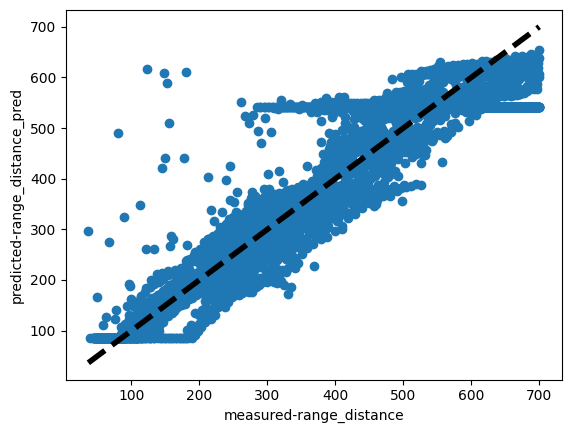

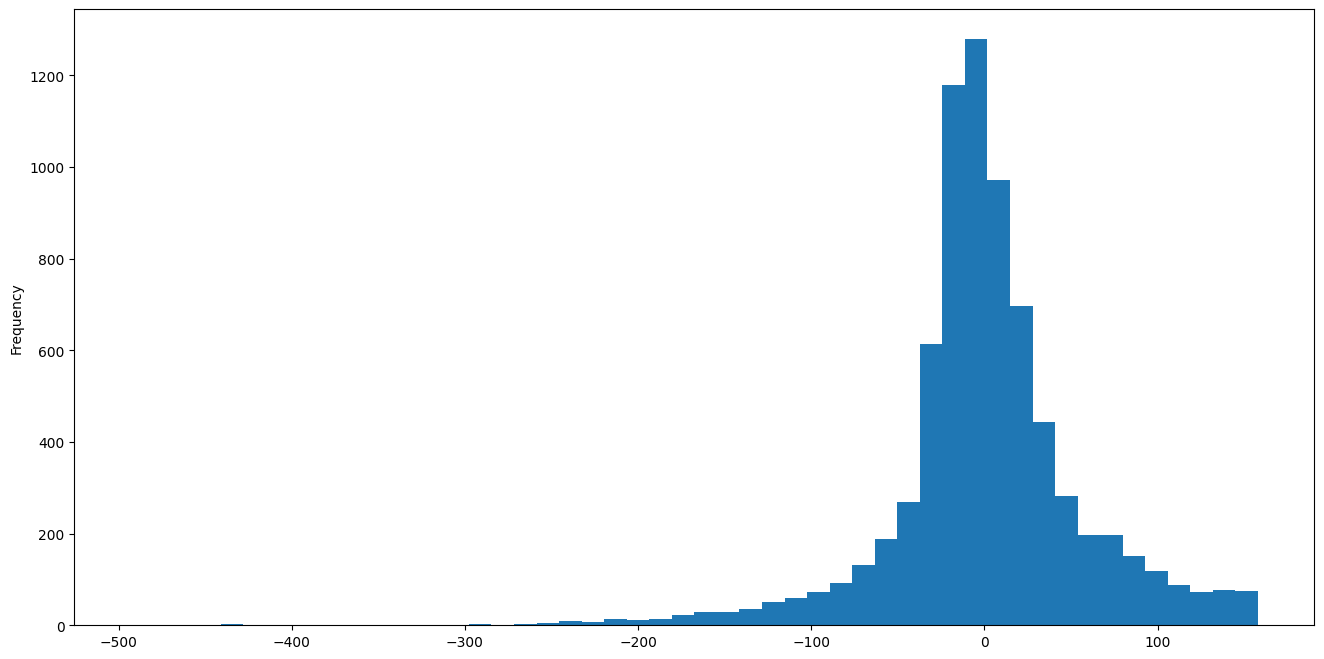

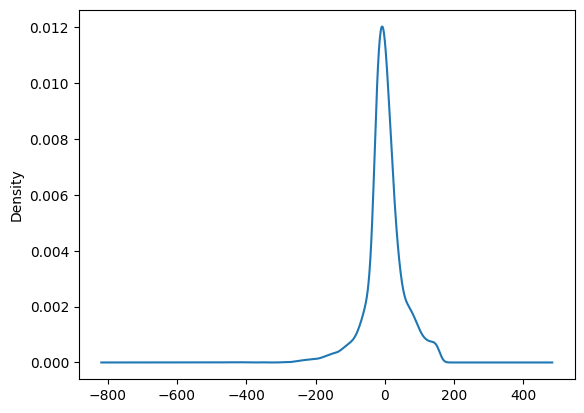

count    7496.000000
mean        0.454909
std        55.881895
min      -493.000000
25%       -22.000000
50%        -2.000000
75%        24.000000
max       158.000000
Name: score, dtype: float64


In [92]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

y_test = predictions['range_distance']
y_predicted = predictions['range_distance_pred']

ax.scatter(y_test, y_predicted)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('measured-range_distance')
ax.set_ylabel('predicted-range_distance_pred')
plt.show()


predictions['score'].plot(kind="hist", bins=50,figsize=(16,8))
plt.show()


predictions['score'].plot(kind="kde")
plt.show()

print(predictions['score'].describe(include=['category']))